### Доверительные интервалы на основе Bootstrap
Будем сэмплировать данные из известной нам выборки с возвращениями, то есть из известной выборки получать выборки такой же длины путём сэмплирования с возвращением. В этом случае мы будем сэмплировать уже не из теоретической функции распределения, а из эмпирической функции распределения, и таким образом, посчитав статистику на каждой из этих выборок, мы с вами оценим эмпирическую функцию распределения. Собственно, в этом и заключается идея Bootstrap.

Verizon — основная региональная телекоммуникационная компания (Incumbent Local Exchange Carrier, ILEC) в западной 
части США. В связи с этим данная компания обязана предоставлять сервис ремонта телекоммуникационного оборудования 
не только для своих клиентов, но и для клиентов других локальных телекоммуникационых компаний (Competing Local Exchange Carriers, CLEC). При этом в случаях, когда время ремонта оборудования для клиентов других компаний существенно выше, чем для собственных, Verizon может быть оштрафована. 

Загрузим доступную нам выборку и проанализируем **среднее время ремонта оборудования для клиентов компании Verizon и среднее время ремонта оборудования для клиентов других компаний.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('verizon.txt', sep = '\t')
data.shape

(1687, 2)

In [3]:
data.head()

,Time,Group
0,17.50,ILEC
1,2.40,ILEC
2,0.00,ILEC
3,0.65,ILEC
4,22.23,ILEC


In [4]:
data['Group'].value_counts()

ILEC    1664
CLEC      23
Name: Group, dtype: int64

- ```ILEC``` - данные по ремонту оборудования для клиентов компании
- ```CLEC``` - данные по ремонту оборудования для клиентов других компании

Можем заменить, что в основном имеем данные для клиентов компании, а не для клиентов других компаний. Ничего страшного, мы все равно можем сравнить среднее время!

Мы хотим каким-то образом сравнить, насколько же отличается среднее время ремонта. Ну сравнивать среднее время ремонта не очень сложно, мы с вами это уже умеем. Мы умеем строить доверительные интервалы на **средние**, поэтому давайте возьмём какую-нибудь другую статистику. Давайте сравним, как же соотносится между собой **медианное время ремонта.**

Посмотрим на распределние клиентов компании и клиентов других компаний

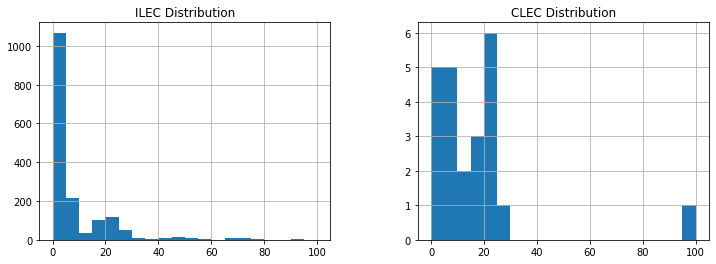

In [5]:
fig, axes = plt.subplots(1,2, figsize = (12, 4))
data[data['Group'] == 'ILEC'].hist(bins = 20, range = (0,100), ax = axes[0])
data[data['Group'] == 'CLEC'].hist(bins = 20, range = (0,100), ax = axes[1])
axes[0].set_title('ILEC Distribution')
axes[1].set_title('CLEC Distribution')
plt.show()

Можно заметить что время ремонта для клиентов компании сильно меньше, чем для клиентов других компаний (основная масса значений концетрируется около нуля). Однако оценивать это глазами не совсем корректно, оценим.

### Bootstrap

In [6]:
# Создадим функцию для получения псевдоподвыборок на основе bootstrap
def get_bootstrap_samples(data, n_samples):
    """
    n_samples - число выборок 
    data - исходная выборка (np.array)
    
    """
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [7]:
# Функция для расчета статистик (квантиль)
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    return boundaries

### Интервальная оценка медианы

In [8]:
# Отделяем клиентов компании
ilec_time_val = data[data['Group'] == 'ILEC']['Time'].values
clec_time_val = data[data['Group'] == 'CLEC']['Time'].values

np.random.seed(0)

ilec_median_scores = list(map(np.median, get_bootstrap_samples(ilec_time_val, n_samples = 1000)))
clec_median_scores = list(map(np.median, get_bootstrap_samples(clec_time_val, n_samples = 1000)))


ilec_median_estimate = stat_intervals(ilec_median_scores, 0.05)
clec_median_estimate = stat_intervals(clec_median_scores, 0.05)

print(f'95% Confidence Interval For the ILEC Median Repair Time: {ilec_median_estimate}')
print(f'95% Confidence Interval For the CLEC Median Repair Time: {clec_median_estimate}')

95% Confidence Interval For the ILEC Median Repair Time: [3.18    3.82525]
95% Confidence Interval For the CLEC Median Repair Time: [ 5.79125 20.     ]


Интервалы не  пересекаются, значит время ремонта оборудования для внутренних клиентов, действительно происходит быстрее, чем для внешних клиентов

### Точечная оценка разности медиан

In [60]:
print('Difference between medians: ', np.median(clec_time_val) - np.median(ilec_time_val))

Difference between medians:  10.74


### Интервальная оценка разности медиан

Что если нам хочется получить интервальную оценку для разности медиан? Во-первых, эти интервалы получились сильно разной длины, ну и, вообще, у нас нет никаких теоретических оснований для того, чтобы просто взять и, скажем, посчитать разность левых и правых границ этого интервала.

Давайте поступим следующим образом. Снова с помощью ```Bootstrap``` сгенерируем выборки для клиентов разных групп и посчитаем на этих выборках медианы независимо. Далее, по полученным данным рассчитаем следующую статистику. Посчитаем разность полученных медиан.

In [64]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(ilec_median_scores, clec_median_scores)))
print("95% Confidence Interval For the Difference Between Medians",  stat_intervals(delta_median_scores, 0.05))

95% Confidence Interval For the Difference Between Medians [ 2.04975 16.63   ]


### Задания из Теста
**1)** Давайте уточним правило трёх сигм. Утверждение: 99.7% вероятностной массы случайной величины ```X∼N(μ,σ^2)``` лежит в интервале ```μ±c⋅σ```. Чему равно точное значение константы ```c```? Округлите ответ до четырёх знаков после десятичной точки. 

In [80]:
from scipy import stats
np.round(norm.ppf(1-(0.003/2)), 4)

2.9677

**2)** В пятилетнем рандомизированном исследовании Гарвардской медицинской школы 11037 испытуемых через день принимали аспирин, а ещё 11034 — плацебо. Исследование было слепым, то есть, испытуемые не знали, что именно они принимают.

За 5 лет инфаркт случился у 104 испытуемых, принимавших аспирин, и у 189 принимавших плацебо. 

Оцените, насколько вероятность инфаркта снижается при приёме аспирина. Округлите ответ до четырёх знаков после десятичной точки.

In [88]:
# Сгенерируем данные эксперимента как данные бинарной классификации
aspirin_sample = np.zeros(11037)
placebo_sample = np.zeros(11034)

aspirin_sample[:104] = 1
placebo_sample[:189] = 1

# Найдем вероятности инфаркта для каждой группы
p_infarkt_aspirin = aspirin_sample.sum()/aspirin_sample.shape[0]
p_infarkt_placebo = placebo_sample.sum()/placebo_sample.shape[0]

print('Probability of Infarkt in Aspiring Group: ', round(p_infarkt_aspirin, 4))
print('Probability of Infarkt in Placebo Group: ', round(p_infarkt_placebo, 4))
print(f'Probability of Infarkt Decrease Taking Aspirin: {round((p_infarkt_placebo - p_infarkt_aspirin),4)}')

Probability of Infarkt in Aspiring Group:  0.0094
Probability of Infarkt in Placebo Group:  0.0171
Probability of Infarkt Decrease Taking Aspirin: 0.0077


**2)** Постройте теперь 95% доверительный интервал для снижения вероятности инфаркта при приёме аспирина. Чему равна его верхняя граница? Округлите ответ до четырёх знаков после десятичной точки.  

In [91]:
def proportions_confint_diff_ind(sample1, sample2, alpha=0.05):    
    z = stats.norm.ppf(1 - alpha / 2)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

conf_inter = proportions_confint_diff_ind(placebo_sample, aspirin_sample)

print(f'Confidence Interval: [{round(conf_inter[0], 4)}, {round(conf_inter[1], 4)}]')

Confidence Interval: [0.0047, 0.0107]


**3)** Продолжим анализировать данные эксперимента Гарвардской медицинской школы.

Для бернуллиевских случайных величин ```X~Ber(p)``` часто вычисляют величину ```p/1-p``` которая называется шансами (odds). Чтобы оценить шансы по выборке, вместо ```p``` нужно подставить ```p^```.

Оцените, во сколько раз понижаются шансы инфаркта при регулярном приёме аспирина. Округлите ответ до четырёх знаков после десятичной точки.

In [95]:
# Определим функцию вычисления шансов
def calculate_odds(data):
    p = data.sum() / data.shape[0]
    return p / (1 - p)

# Считаем шансы для групп
odds_aspirin = calculate_odds(aspirin_sample)
odds_placebo = calculate_odds(placebo_sample)

# Отношение шансов (во сколько раз понижаются шансы инфаркта при регулярном приёме аспирина)
odds_ration = odds_placebo/odds_aspirin

print('Infark Odds (Aspirin Group): ', round(odds_aspirin, 4))
print('Infark Odds (Placebo Group): ', round(odds_placebo, 4))
print('Odds Ration Between Groups: ', round(odds_ration, 4))

Infark Odds (Aspirin Group):  0.0095
Infark Odds (Placebo Group):  0.0174
Odds Ration Between Groups:  1.8321


**4)** Величина, которую вы оценили в предыдущем вопросе, называется отношением шансов. Постройте для отношения шансов 95% доверительный интервал с помощью бутстрепа. Чему равна его нижняя граница? Округлите ответ до 4 знаков после десятичной точки.

Чтобы получить в точности такой же доверительный интервал, как у нас:

- Cоставьте векторы исходов в контрольной и тестовой выборках так, чтобы в начале шли все единицы, а потом все нули;
- Установите random ```seed=0```;
- Cделайте по 1000 псевдовыборок из каждой группы пациентов с помощью функции ```get_bootstrap_samples```

In [138]:
np.random.seed(0)

odds_aspirin_data = np.array(list(map(calculate_odds, get_bootstrap_samples(aspirin_sample, 1000))))
odds_placebo_data = np.array(list(map(calculate_odds, get_bootstrap_samples(placebo_sample, 1000))))

odds_ration = odds_placebo_data / odds_aspirin_data 

print('Confidence Interval For Odss Ration: ', stat_intervals(odds_ration, 0.05))

Confidence Interval For Odss Ration:  [1.44419465 2.34321168]
